In [1]:
import pandas as pd
import pickle
from datasets import Dataset
from collections import Counter
from utils import id2label, label2id, classes
import matplotlib.pyplot as plt
import numpy as np
# import torch
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# from torch.nn.functional import softmax
# from transformers import AutoTokenizer, DataCollatorWithPadding
# from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm.notebook import tqdm as tqdm

from kleinberg import burst_detection, enumerate_bursts, burst_weights

## Constants

In [2]:
df = pd.read_json('all.json')
history_dataset = df[df.genre=='history']
titles = history_dataset['title'].to_list()
DATA = Dataset.from_pandas(history_dataset)

In [3]:
# id of paragraph where each chapter starts
titles_d = {}
for i in range(len(titles)):
    if titles[i] not in titles_d:
        titles_d[titles[i]] = i
        
titles_inv = {val:key for key, val in titles_d.items()}
titles_inv[3065] = 'A. TO THE REIGN OF JAMES I'
titles_d['A. TO THE REIGN OF JAMES I'] = 3065

In [23]:
for el in titles_d.values():
    print(el)

0
77
156
238
286
340
366
405
426
478
538
578
648
708
812
912
961
1050
1132
1208
1239
1285
1359
1402
1455
1500
1535
1579
1626
1676
1715
1786
1847
1920
1971
2038
2096
2152
2193
2245
2308
2399
2489
2537
2617
2665
2729
2797
2849
2915
2966
3008
3065
3137
3204
3273
3357
3424
3539
3651
3730
3792
3860
4006
4109
4205
4311
4381
4482
4582
4669
4738
4797
4867
4940
3065


In [4]:
# on which paragraph and chapter each volume starts
volume_start = [('I', 0), ('XII', 708), ('XXIV', 1500), ('XXXVIII', 2245), 
                ('XLV', 2797), ('LX', 4006), ('end', 5046)]

In [5]:
volume_names = ['Volume 1. (1762) The Early History of England, Part 1', 
                'Volume 2. (1762) The Early History of England, Part 2',
                'Volume 3. (1759) The History of the House of Tudor, Part 1', 
                'Volume 4. (1759) The History of the House of Tudor, Part 2', 
                'Volume 5. (1754) The History of Great Britain, Part 1', 
                'Volume 6. (1757) The History of Great Britain, Part 2']


volume_names_short = ['Volume 1 (1762)', 
                'Volume 2 (1762)',
                'Volume 3 (1759)', 
                'Volume 4 (1759)', 
                'Volume 5 (1754)', 
                'Volume 6 (1757)']

In [6]:
classes

['dialogues',
 'dissertation',
 'enquiry',
 'essay',
 'history',
 'political discourses',
 'treatise']

In [7]:
colors = {'dialogues' : 'red', 
          'dissertation' : 'orange', 
          'enquiry' : 'yellow', 
          'essay': 'green', 
          'history' : 'grey',
          'political discourses' : 'blue', 
          'treatise' : 'purple'} 

In [8]:
rectangle_starts = {'dialogues' : (0.4, 0.5), 
          'dissertation' : (0.5, 0.6), 
          'enquiry' : (0.6, 0.7), 
          'essay': (0.7, 0.8), 
          'history' : (1, 2),
          'political discourses' : (0.8, 0.9), 
          'treatise' : (0.9, 1)} 

## Predictions

In [ ]:
def predict_transformer():
    model_name = 'models/TurkuNLP/eccobert-base-cased-v1-finetuned/checkpoint-775'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=512)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=len(id2label), 
        id2label=id2label, 
        label2id=label2id).to(device)

    tokenized_dataset = DATA.map(preprocess_function, batched=True)

    pred = torch.tensor([]).to(device)

    for line in tqdm(tokenized_dataset):
        text = line['text']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
#         predicted_class_id = logits.argmax().item()
        pred = torch.cat((pred, logits), 0)
    
    pred = softmax(pred, dim=-1)
        
    return pred.cpu()

In [9]:
def predict_logreg(model_path='models/logreg.pkl', vect_path='models/tfidf_vectorizer.pkl'):

    # load
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    with open(vect_path, 'rb') as f:
        vect = pickle.load(f)

    x_test = vect.transform(DATA['text'])
    pred = model.predict_proba(x_test)
    
    return pred

In [10]:
pred_logreg = predict_logreg('models/logreg_stopwords.pkl', 'models/tfidf_vectorizer_stopwords.pkl')

In [ ]:
pred_transformer = predict_transformer()

## Average chapter genre

Does not give us anything because the models predict history mostly

In [ ]:
chapter_starts = [(key, value) for key, value in titles_inv.items()]
chapter_starts.append((5046, 'end'))

for i in range(len(chapter_starts)-1):
    chapter = chapter_starts[i]
    start = chapter[0]
    end = chapter_starts[i+1][0]
    genres = []
    for par in pred_logreg[start:end]:
        genre = par.argmax()
        genres.append(genre)
    print(chapter[1], '\t\t', id2label[max(set(genres), key=genres.count)])


## Timeline with bursts

In [11]:
def extract_bursts(volume, genre_id, pred=pred_logreg):
    
    threshold = 0.15
    weight_threshold = 0.5
    
    
    # borders of the volume
    start = volume_start[volume][1] # starting paragraph
    end = volume_start[volume+1][1] # ending paragraph + 1
    
    target_events = [1 if line[genre_id] >= threshold else 0 for line in pred[start:end]]
    
    events = [1 for i in range(len(target_events))]
    
    #number of target events at each time point
    r = np.array(target_events, dtype=float)
    
    if not sum(r): # no target events
        return [], []
    
    #total number of events at each time point
    d = np.array(events, dtype=float)
    #number of time points
    n = len(r)

    #find the optimal state sequence (q)
    q, d, r, p = burst_detection(r, d, n, s=2, gamma=0.01, smooth_win=1)

    #enumerate bursts based on the optimal state sequence
    bursts = enumerate_bursts(q, 'burstLabel')

    #find weight of bursts
    weighted_bursts = burst_weights(bursts, r, d, p)
    
    res = weighted_bursts[weighted_bursts['weight'] >= weight_threshold]
    
    lefts = res['begin'].to_list()
    rights = res['end'].to_list()
    
    return lefts, rights

In [12]:
def draw_genre(volume, genre, pred=pred_logreg):
    
    genre_id = label2id[genre]
        
    lefts, rights = extract_bursts(volume, genre_id, pred)
#     print(f'len {genre} is {len(lefts)}')

    def draw_section(left, right, genre):

        def f(t):
            return 1

        section = np.arange(left, right+1, 1)
        plt.fill_between(section, 
                         y1 = rectangle_starts[genre][0],
                         y2 = rectangle_starts[genre][1],
                         alpha = 0.7, color=colors[genre])

    for l, r in zip(lefts, rights):
        draw_section(l, r, genre)

In [13]:
def draw_volume(volume, pred=pred_logreg, draw_bursts=True):
    n = 7 # number of genres

    volume = volume - 1 # volume number
    fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')

    start = volume_start[volume][1] # starting paragraph
    end = volume_start[volume+1][1] # ending paragraph + 1

    x = np.array([i for i in range(len(pred[start:end]))]) # go through paragraphs
    for i in range(n):
        y = pred.T[i][start:end]
        y = [v if v > 0.05 else None for v in y]
        ax.scatter(x,y, label=id2label[i], color=colors[id2label[i]], alpha=0.3) # draw dots

    ax.legend()
    plt.title(volume_names[volume])

    titles = [titles_inv[el] for el in titles_inv if el >= start and el < end]
    ticks = [el-start for el in titles_inv if el >= start and el < end]
    ax.xaxis.set_ticks(ticks, labels=titles, fontsize=10)

    # chapter borders
    for t in ticks:
        plt.axvline(x = t)
        
    if draw_bursts:
        for genre in label2id.keys():
            draw_genre(volume, genre)
        
    plt.show()

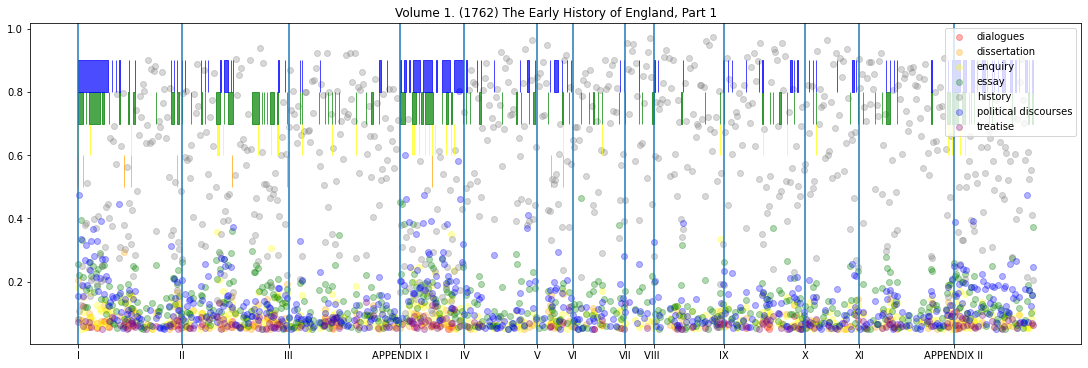

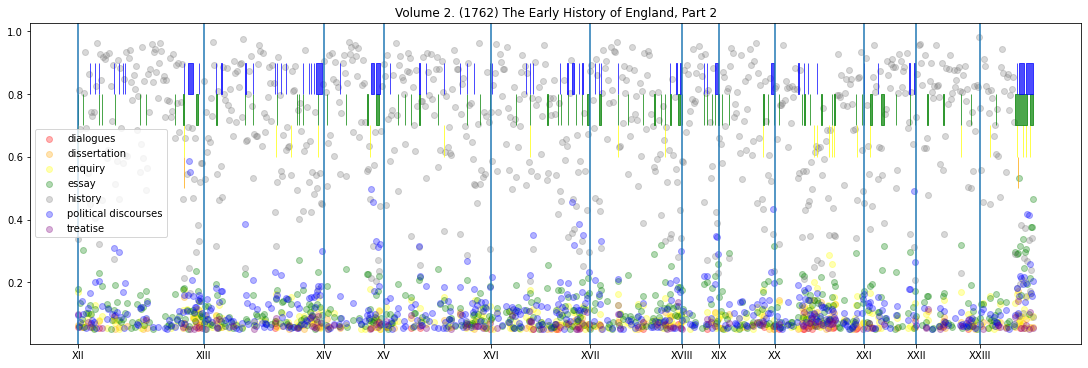

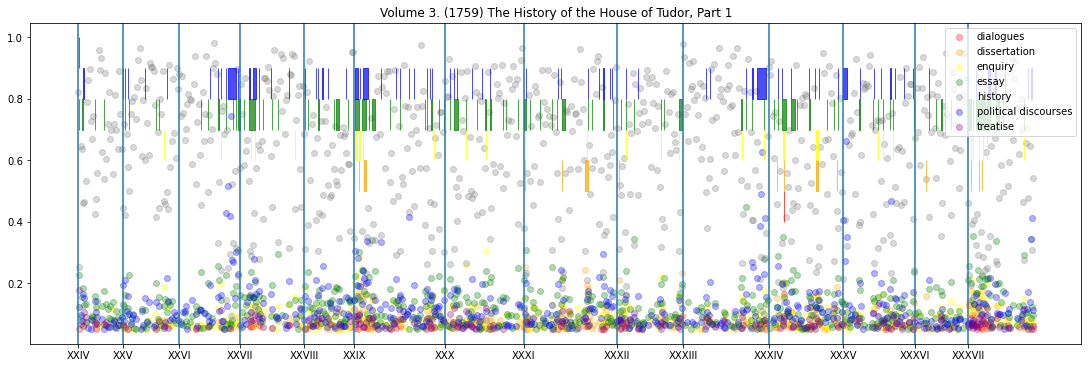

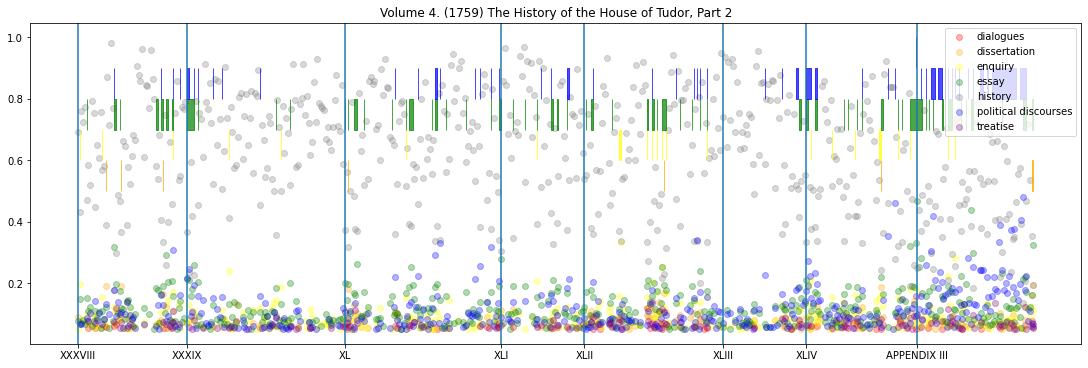

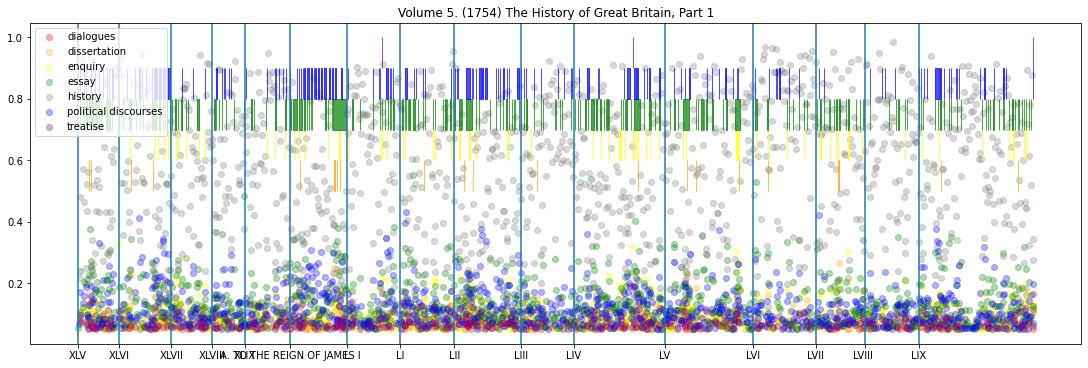

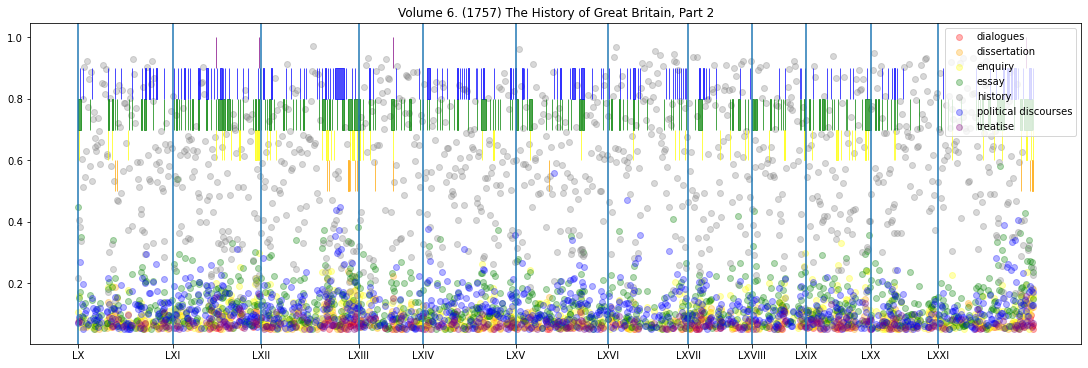

In [75]:
for i in range(1, 7):
    draw_volume(i)

## Additional table

In [14]:
pred = pred_logreg
extracted_bursts = []
total = 0
for volume in range(0, 6): # normal order
    for genre_id in range(0, 7):
        lefts, rights = extract_bursts(volume, genre_id, pred)
        total += len(lefts)
        for l, r in zip(lefts, rights):
            extracted_bursts.append((volume, genre_id, l, r))

In [15]:
def find_chapter(beginning):
    chapter_starts = list(titles_inv.keys())
    
    for i in range(len(chapter_starts)):
        if chapter_starts[i] > beginning:
            ch = titles_inv[chapter_starts[i-1]]
            return ch
        elif chapter_starts[i] == beginning:
            ch = titles_inv[chapter_starts[i]]
            return ch
    ch = titles_inv[chapter_starts[-1]]
    return ch

In [16]:
def volume_to_start(volume):
    
    d = {0:0, 
        1:708,
        2:1500,
        3:2245,
        4:2797,
        5:4006}
    
    return d[volume]

In [17]:
df = pd.DataFrame(extracted_bursts, columns=['volume', 'genre', 'left', 'right'])
df['burst_len'] = df['right'] - df['left'] + 1
df['volume_number'] = df['volume']
df['volume'] = df['volume'].apply(lambda x: volume_names_short[x])
df['genre'] = df['genre'].apply(lambda x: id2label[x])
# добавить к номеру параграфа число в зависимости от книги
df['add_to_paragraph_number'] = df['volume_number'].apply(volume_to_start)
df['full_paragraph_number'] = df['left'] + df['add_to_paragraph_number']
# приписать номер главы и номер параграфа в главе
df['chapter'] = df['full_paragraph_number'].apply(find_chapter)
df['chapter_start'] = df['chapter'].apply(lambda x: titles_d[x])
df['start_in_chapter'] = df['full_paragraph_number'] - df['chapter_start']

In [20]:
df.to_csv('extracted_bursts_full.csv')

In [47]:
df[['volume', 'genre', 'burst_len', 'chapter', 'start_in_chapter']].sort_values(by='burst_len', ascending=False)[:20]

,volume,genre,burst_len,chapter,start_in_chapter
140,Volume 1 (1762),political discourses,23,I,0
856,Volume 5 (1754),essay,17,A. TO THE REIGN OF JAMES I,55
714,Volume 4 (1759),political discourses,15,APPENDIX III,43
1451,Volume 6 (1757),political discourses,11,LXII,80
254,Volume 2 (1762),essay,11,XXIII,29
858,Volume 5 (1754),essay,9,LIV,76
42,Volume 1 (1762),essay,9,I,8
857,Volume 5 (1754),essay,9,LV,23
1281,Volume 6 (1757),essay,9,LXXI,94
1282,Volume 6 (1757),essay,9,LXXI,64


In [48]:
df

,volume,genre,left,right,burst_len,volume_number,add_to_paragraph_number,full_paragraph_number,chapter,chapter_start,start_in_chapter
0,Volume 1 (1762),dissertation,0,0,1,0,0,0,I,0,0
1,Volume 1 (1762),dissertation,4,4,1,0,0,4,I,0,4
2,Volume 1 (1762),dissertation,34,34,1,0,0,34,I,0,34
3,Volume 1 (1762),dissertation,39,39,1,0,0,39,I,0,39
4,Volume 1 (1762),dissertation,73,73,1,0,0,73,I,0,73
...,...,...,...,...,...,...,...,...,...,...,...
1592,Volume 6 (1757),political discourses,1037,1037,1,5,4006,5043,LXXI,4940,103
1593,Volume 6 (1757),treatise,150,150,1,5,4006,4156,LXI,4109,47
1594,Volume 6 (1757),treatise,197,197,1,5,4006,4203,LXI,4109,94
1595,Volume 6 (1757),treatise,342,342,1,5,4006,4348,LXIII,4311,37


In [ ]:
df[['volume', 'genre', 'burst_len', 'chapter', 'start_in_chapter']].to_csv('extracted_bursts.csv')

In [49]:
aggregated = pd.DataFrame()
aggregated['volume'] = volume_names_short
aggregated = aggregated.set_index('volume')
aggregated['n_bursts'] = list(df.groupby(['volume']).count()['left'])
aggregated['n_paragraphs'] = list(df[['volume', 'burst_len']].groupby(['volume']).sum()['burst_len'])
aggregated['years'] = [1762, 1762.5, 1759, 1759.5, 1754, 1757]
aggregated['total_n_paragraphs'] = [708, 792, 745, 552, 1209, 1040]
aggregated['percentage_paragraphs'] = aggregated['n_paragraphs'] / aggregated['total_n_paragraphs']
aggregated = aggregated.sort_values(by=['years'])

In [50]:
aggregated

,n_bursts,n_paragraphs,years,total_n_paragraphs,percentage_paragraphs
volume,,,,,
Volume 5 (1754),442,676,1754.0,1209,0.559140
Volume 6 (1757),389,581,1757.0,1040,0.558654
Volume 3 (1759),220,317,1759.0,745,0.425503
Volume 4 (1759),145,221,1759.5,552,0.400362
Volume 1 (1762),228,398,1762.0,708,0.562147
Volume 2 (1762),173,252,1762.5,792,0.318182


<AxesSubplot:xlabel='volume'>

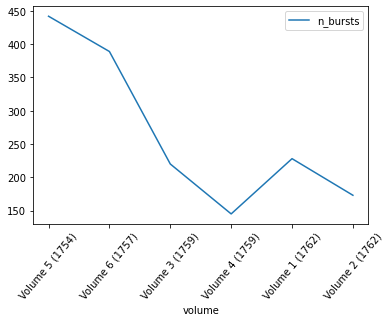

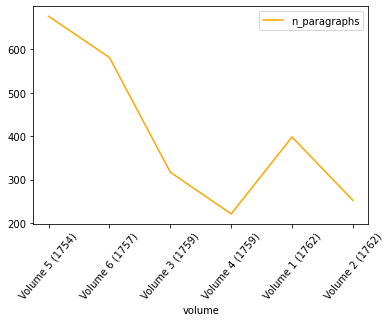

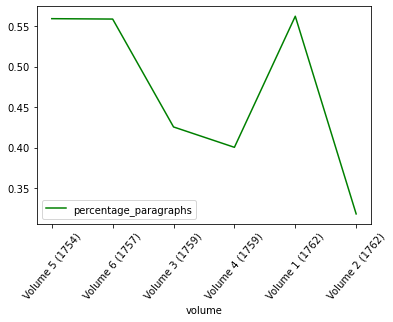

In [51]:
aggregated[['n_bursts']].plot.line(rot=50)
aggregated[['n_paragraphs']].plot.line(rot=50, color='orange')
aggregated[['percentage_paragraphs']].plot.line(rot=50, color='green')

In [61]:
df.groupby(['volume', 'genre'])['burst_len'].sum()

volume           genre               
Volume 1 (1762)  dissertation             10
                 enquiry                  34
                 essay                   176
                 political discourses    178
Volume 2 (1762)  dissertation              2
                 enquiry                  24
                 essay                   119
                 political discourses    107
Volume 3 (1759)  dialogues                 1
                 dissertation             19
                 enquiry                  36
                 essay                   149
                 political discourses    111
                 treatise                  1
Volume 4 (1759)  dissertation              8
                 enquiry                  25
                 essay                   103
                 political discourses     84
                 treatise                  1
Volume 5 (1754)  dissertation             23
                 enquiry                  85
                 

In [67]:
df.groupby(['volume', 'genre']).count()['burst_len']

volume           genre               
Volume 1 (1762)  dissertation             10
                 enquiry                  32
                 essay                    98
                 political discourses     88
Volume 2 (1762)  dissertation              2
                 enquiry                  24
                 essay                    81
                 political discourses     66
Volume 3 (1759)  dialogues                 1
                 dissertation             15
                 enquiry                  32
                 essay                    94
                 political discourses     77
                 treatise                  1
Volume 4 (1759)  dissertation              7
                 enquiry                  23
                 essay                    63
                 political discourses     51
                 treatise                  1
Volume 5 (1754)  dissertation             21
                 enquiry                  69
                 